In [10]:
import matplotlib.pyplot as plt
import matplotlib.ticker
import numpy as np
import pandas as pd
import pickle
import seaborn as sns

sns.set_theme()

from evaluation.serialization import Serializer
from constants import TYPES

In [12]:
cv_training_metrics = Serializer.load("cv_training_metrics")
cv_final_metrics = Serializer.load("cv_metrics")
final_training_metrics = Serializer.load("final_training_metrics")
final_metrics = Serializer.load("final_metrics")

In [14]:
with open("../data/pathway_distribution.pickle", "rb") as f:
    proportions = pickle.load(f)

In [50]:
relevant_data = final_metrics\
    .query("kingdom == 'overall' and label != 'overall'")\
    .groupby(["metric", "label", "kingdom"])\
    .agg(["mean", "std"])\
    .sort_values(by="label")\
    ["value"]

relevant_data["ci"] = 1.96 * relevant_data["std"]

In [49]:
cv_data = cv_final_metrics\
    .query("kingdom == 'overall' and label != 'overall' and metric != 'accuracy'")\
    .groupby(["metric", "label", "kingdom"])\
    .agg(["mean", "std"])\
    .sort_values(by="metric")\
    ["value"]

cv_data["ci"] = 1.96 * relevant_data["std"]

# Test Set

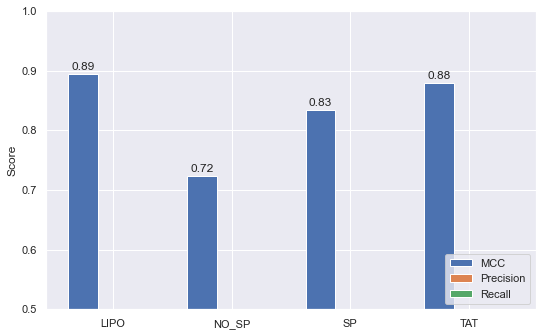

In [13]:
fig, ax = plt.subplots()
labels = sorted([type for type in TYPES])
r1 = np.arange(len(labels))
width = 0.25
r2 = r1 + width
r3 = r2 + width

mcc_values = ax.bar(
    r1,
    relevant_data.query("metric == 'mcc'")["value"],
    width,
    label="MCC"
)

precision_values = ax.bar(
    r2,
    relevant_data.query("metric == 'precision'")["value"],
    width,
    label="Precision"
)

recall_values = ax.bar(
    r3,
    relevant_data.query("metric == 'recall'")["value"],
    width,
    label="Recall"
)

ax.set_ylabel("Score")
ax.set_xticks(r2)
ax.set_xticklabels(labels)
ax.legend(loc="lower right")

ax.set_ylim([0.5, 1])

ax.bar_label(mcc_values, padding=2, fmt="%.2f")
ax.bar_label(precision_values, padding=2, fmt="%.2f")
ax.bar_label(recall_values, padding=2, fmt="%.2f")

fig.tight_layout()

fig.set_size_inches(8, 5)
fig.savefig("output/performance_by_pathway.png", dpi=240)

# Test set and CV

In [39]:
import matplotlib
matplotlib.rcParams.update({"errorbar.capsize": 5})
from colors import final_color, cv_color

ValueError: shape mismatch: objects cannot be broadcast to a single shape

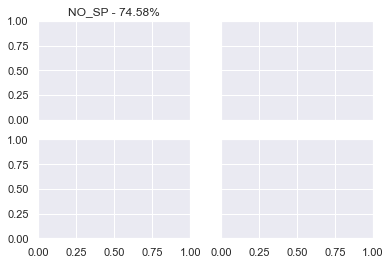

In [52]:
bar_width = 0.3
final_data = relevant_data.query("metric != 'accuracy'").sort_values(by="metric")
metrics = ["mcc", "precision", "recall"]
labels = ["MCC", "Precision", "Recall"]
r1 = np.arange(len(metrics))
r2 = r1 + bar_width

fig = plt.figure()
gs = fig.add_gridspec(2, 2)
((ax1, ax2), (ax3, ax4)) = gs.subplots(sharex="col", sharey="row")
for ax, type in zip([ax1, ax2, ax3, ax4], TYPES):
    relevant_cv_data = cv_data.query(f"label == '{type}'")
    relevant_final_data = final_data.query(f"label == '{type}'")
    ax.set_title(f"{type} - {proportions[type]:.2%}")
    final_values = ax.bar(
        r1,
        final_data["mean"],
        yerr=relevant_data["ci"],
        width=bar_width,
        color=final_color,
        label="Final model"
    )

    cv_values = ax.bar(
        r2,
        relevant_cv_data["mean"],
        yerr=relevant_cv_data["ci"],
        width=bar_width,
        color=cv_color,
        label="CV average"
    )
    ax.set_ylabel("Score")
    ax.set_xticks(r1 + bar_width/2)
    ax.set_xticklabels(labels)
    ax.set_ylim([0.0, 1.03])
    ax.label_outer()

    ax.bar_label(final_values, padding=2, fmt="%.2f")
    ax.bar_label(cv_values, padding=2, fmt="%.2f")

plt.legend(loc="lower right")
fig.tight_layout()
fig.set_size_inches(10, 7)
fig.savefig("output/performance_by_pathway_vs_cv.png", dpi=240)

In [53]:
final_data.query("metric == 'mcc'").sort_values(by="mean")

mean       std        ci
metric label kingdom                              
mcc    M     overall  0.777919  0.014236  0.027903
       S     overall  0.866310  0.005425  0.010632
       T     overall  0.884537  0.017199  0.033710
       L     overall  0.905925  0.009342  0.018310
       O     overall  0.914518  0.003570  0.006997
       I     overall  0.942209  0.003649  0.007152